# Credit Card Customer Segmentation

## Goal

We are a data scients working in a bank. The goal is to segment the customers so that we can apply different business strategies to each. For example we could provide higher limits for customers that use the card a lot but spend little money. Or give incentives to those with high income that doesn't use it as much.<br>
We will apply the K-means algorithm to segment the data.<br>
The output should be a group for each client and an explanation of its characteristics.

## Libraries

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans  
from sklearn.preprocessing import StandardScaler

## Data Dictionary

- **customer_id**: unique identifier for each customer.
- **age**: customer age in years.
- **gender**: customer gender (M or F).
- **dependent_count**: number of dependents of each customer.
- **education_level**: level of education ("High School", "Graduate", etc.).
- **marital_status**: marital status ("Single", "Married", etc.).
- **estimated_income**: the estimated income for the customer projected by the data science team.
- **months_on_book**: time as a customer in months.
- **total_relationship_count**: number of times the customer contacted the company.
- **months_inactive_12_mon**: number of months the customer did not use the credit card in the last 12 months.
- **credit_limit**: customer's credit limit.
- **total_trans_amount**: the overall amount of money spent on the card by the customer.
- **total_trans_count**: the overall number of times the customer used the card.
- **avg_utilization_ratio**: daily average utilization ratio.

## Load data

In [2]:
ccc_df = pd.read_csv('data/credit_card_customers.csv')

## EDA

In [7]:
ccc_df.shape

(10127, 14)

In [8]:
ccc_df.head(5)

,customer_id,age,gender,dependent_count,education_level,marital_status,estimated_income,months_on_book,total_relationship_count,months_inactive_12_mon,credit_limit,total_trans_amount,total_trans_count,avg_utilization_ratio
0,768805383,45,M,3,High School,Married,69000,39,5,1,12691.0,1144,42,0.061
1,818770008,49,F,5,Graduate,Single,24000,44,6,1,8256.0,1291,33,0.105
2,713982108,51,M,3,Graduate,Married,93000,36,4,1,3418.0,1887,20,0.000
3,769911858,40,F,4,High School,Unknown,37000,34,3,4,3313.0,1171,20,0.760
4,709106358,40,M,3,Uneducated,Married,65000,21,5,1,4716.0,816,28,0.000


In [21]:
ccc_df['education_level'].value_counts(normalize=True)

education_level
Graduate         0.363879
High School      0.232152
Uneducated       0.173299
College          0.117705
Post-Graduate    0.060827
Doctorate        0.052138
Name: proportion, dtype: float64

### Observations

- There are 10k observations/customers
- We have 14 features
- Age, normally distributed min 26 max 73, avg 43
- Gender 53% female
- Avg dependant 2
- Most common education level is Graduate
- 46% are married, 39% single
- Income mean 62k, min 20k, max 200k
- Avg months on book is around 36 months
- Max inactivity in the last 12 mo is 6mo, the most common is 3mo
- Credit limit range [1438.3, 34,516], has a long tail distribution
- Total transactions amount [510, 18484], it has a long tail distribution

## Feature Engineering I

In [17]:
ccc_modified = ccc_df.copy()

### Categorical

Let's deal with the categorical variables

In [18]:
ccc_modified['gender'] = ccc_modified['gender'].apply(lambda row: 1 if row == 'F' else 0)

In [19]:
# Let's encode the level of education in sequence

mapper = {
    'Uneducated': 0,
    'High School': 1,
    'College': 2,
    'Graduate': 3,
    'Post-Graduate': 4,
    'Doctorate':  5
}

ccc_modified['education_level'] = ccc_modified['education_level'].map(mapper)


In [20]:
"""
for marital status we can't encode them as the previous one 
because the values are not related, there is no 
order of magnitude between them, lets one-hot encode them
"""

ccc_modified = pd.get_dummies(ccc_modified, columns=['marital_status'])

### Numerical

Let's scale our data to be on the same scale

In [23]:
# We need to remove the Customer ID
customer_id = ccc_modified['customer_id']
ccc_modified.drop('customer_id', axis=1, inplace=True)

# Scale the data
scaler = StandardScaler()
ccc_modified = scaler.fit_transform(ccc_modified)

# Convert back to DataFrame
ccc_scaled = pd.DataFrame(ccc_modified)


In [24]:
ccc_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,-0.165406,-1.059956,0.503368,-0.752211,0.175810,0.384621,0.763943,-1.327136,0.446622,-0.959707,-0.973895,-0.775882,-0.282405,1.077338,-0.798507,-0.282609
1,0.333570,0.943436,2.043199,0.662787,-0.967166,1.010715,1.407306,-1.327136,-0.041367,-0.916433,-1.357340,-0.616276,-0.282405,-0.928214,1.252337,-0.282609
2,0.583058,-1.059956,0.503368,0.662787,0.785397,0.008965,0.120579,-1.327136,-0.573698,-0.740982,-1.911206,-0.997155,-0.282405,1.077338,-0.798507,-0.282609
3,-0.789126,0.943436,1.273283,-0.752211,-0.636973,-0.241473,-0.522785,1.641478,-0.585251,-0.951758,-1.911206,1.759686,-0.282405,-0.928214,-0.798507,3.538459
4,-0.789126,-1.059956,0.503368,-1.459710,0.074212,-1.869317,0.763943,-1.327136,-0.430877,-1.056263,-1.570365,-0.997155,-0.282405,1.077338,-0.798507,-0.282609


## Model fitting

We need to iterate to find the best number of clusters

/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

<Axes: >

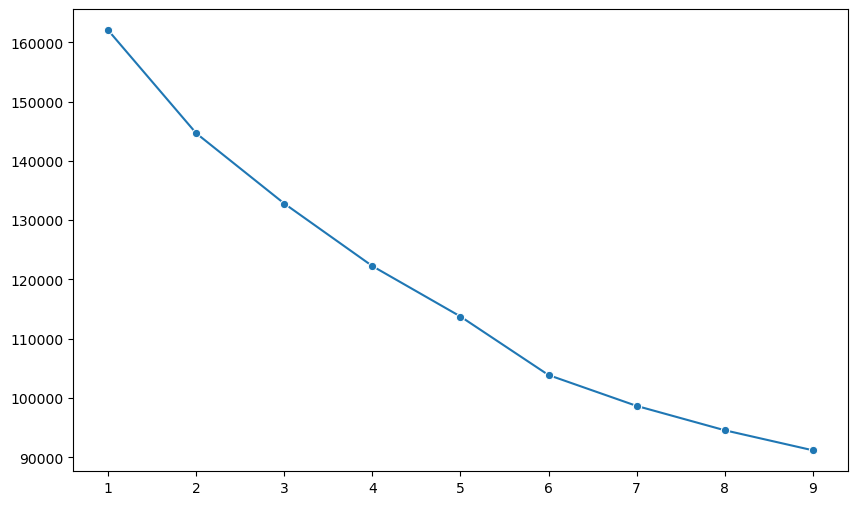

In [34]:
inertias = []
clusters = [ k for k in range(1,10)]

for k in range(1,10):
    model = KMeans(n_clusters=k)
    model.fit_predict(ccc_scaled)
    
    inertias.append(model.inertia_)
    
    
# Create a line plot
plt.figure(figsize=(10, 6))
sns.lineplot(x=clusters, y=inertias, marker='o')
    

From the Inertias we can see that the right number of clusters is between 4 and 6

In [42]:
model = KMeans(n_clusters=6)
clusters = model.fit_predict(ccc_scaled)
clusters = clusters + 1
pd.Series(clusters).value_counts(normalize=True)


/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


5    0.316777
3    0.285771
1    0.165004
6    0.086403
4    0.073072
2    0.072973
Name: proportion, dtype: float64

Fitting our model it seems that cluster 5 and 3 has most of the population.

Let's analyze the results compared with the inital data 

In [45]:
# to the original dataframe lets add the cluster number
ccc_df['cluster_number'] = clusters

In [52]:
numerical_features = ccc_df.select_dtypes(include=['number']).columns.drop('customer_id')

In [82]:
numerical_describe = round(ccc_df[numerical_features].groupby(by='cluster_number').agg(['count', 'mean', 'std']), 1)
numerical_describe.T

cluster_number                         1        2        3        4        5  \
age                      count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean       47.2     45.2     46.1     45.6     46.8   
                         std         6.9      7.5      8.9      6.8      8.1   
dependent_count          count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean        2.5      2.4      2.2      2.5      2.3   
                         std         1.2      1.3      1.3      1.3      1.3   
estimated_income         count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean   114845.0  61129.9  47225.3  61691.9  46159.6   
                         std     38808.7  38318.3  24913.3  37063.7  23325.4   
months_on_book           count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean       36.6     35.2     35.7     35.2     36.3   
                         std         7.2      7.4      8.6      7.2      8.0   
total_relationship_count count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean        4.1      3.9      3.9      3.8      4.0   
                         std         1.5      1.5      1.5      1.6      1.5   
months_inactive_12_mon   count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean        2.4      2.4      2.4      2.3      2.3   
                         std         1.0      1.0      1.0      1.0      1.0   
credit_limit             count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean    19717.4   9202.7   5039.4   9283.9   4118.1   
                         std     10098.6   9398.0   4513.4   9405.8   3147.1   
total_trans_amount       count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean     3159.0   4393.1   3715.9   4590.5   3266.0   
                         std      1835.0   3207.6   1520.9   3106.3   1578.8   
total_trans_count        count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean       55.4     66.4     64.7     66.5     58.0   
                         std        19.9     21.9     17.7     21.9     20.6   
avg_utilization_ratio    count    1671.0    739.0   2894.0    740.0   3208.0   
                         mean        0.1      0.3      0.3      0.3      0.4   
                         std         0.1      0.3      0.3      0.3      0.3   

cluster_number                        6  
age                      count    875.0  
                         mean      45.4  
                         std        7.8  
dependent_count          count    875.0  
                         mean       2.3  
                         std        1.3  
estimated_income         count    875.0  
                         mean   69923.4  
                         std    39800.6  
months_on_book           count    875.0  
                         mean      35.1  
                         std        7.9  
total_relationship_count count    875.0  
                         mean       2.2  
                         std        1.2  
months_inactive_12_mon   count    875.0  
                         mean       2.2  
                         std        1.0  
credit_limit             count    875.0  
                         mean   14860.0  
                         std    10821.3  
total_trans_amount       count    875.0  
                         mean   13082.2  
                         std     2984.9  
total_trans_count        count    875.0  
                         mean     105.9  
                         std       13.4  
avg_utilization_ratio    count    875.0  
                         mean       0.2  
                         std        0.2

### Observations

- The clusters look like the are evenly distributed by: age, months_on_book, months_inactive_12_month
- The following features are the ones that give the clusters their characteristics: 
  - estimated_income, total_relationship, credit limit, total_trans_amount, total_trans_count, avg_utilization_ratio

/Users/dani-guerra/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


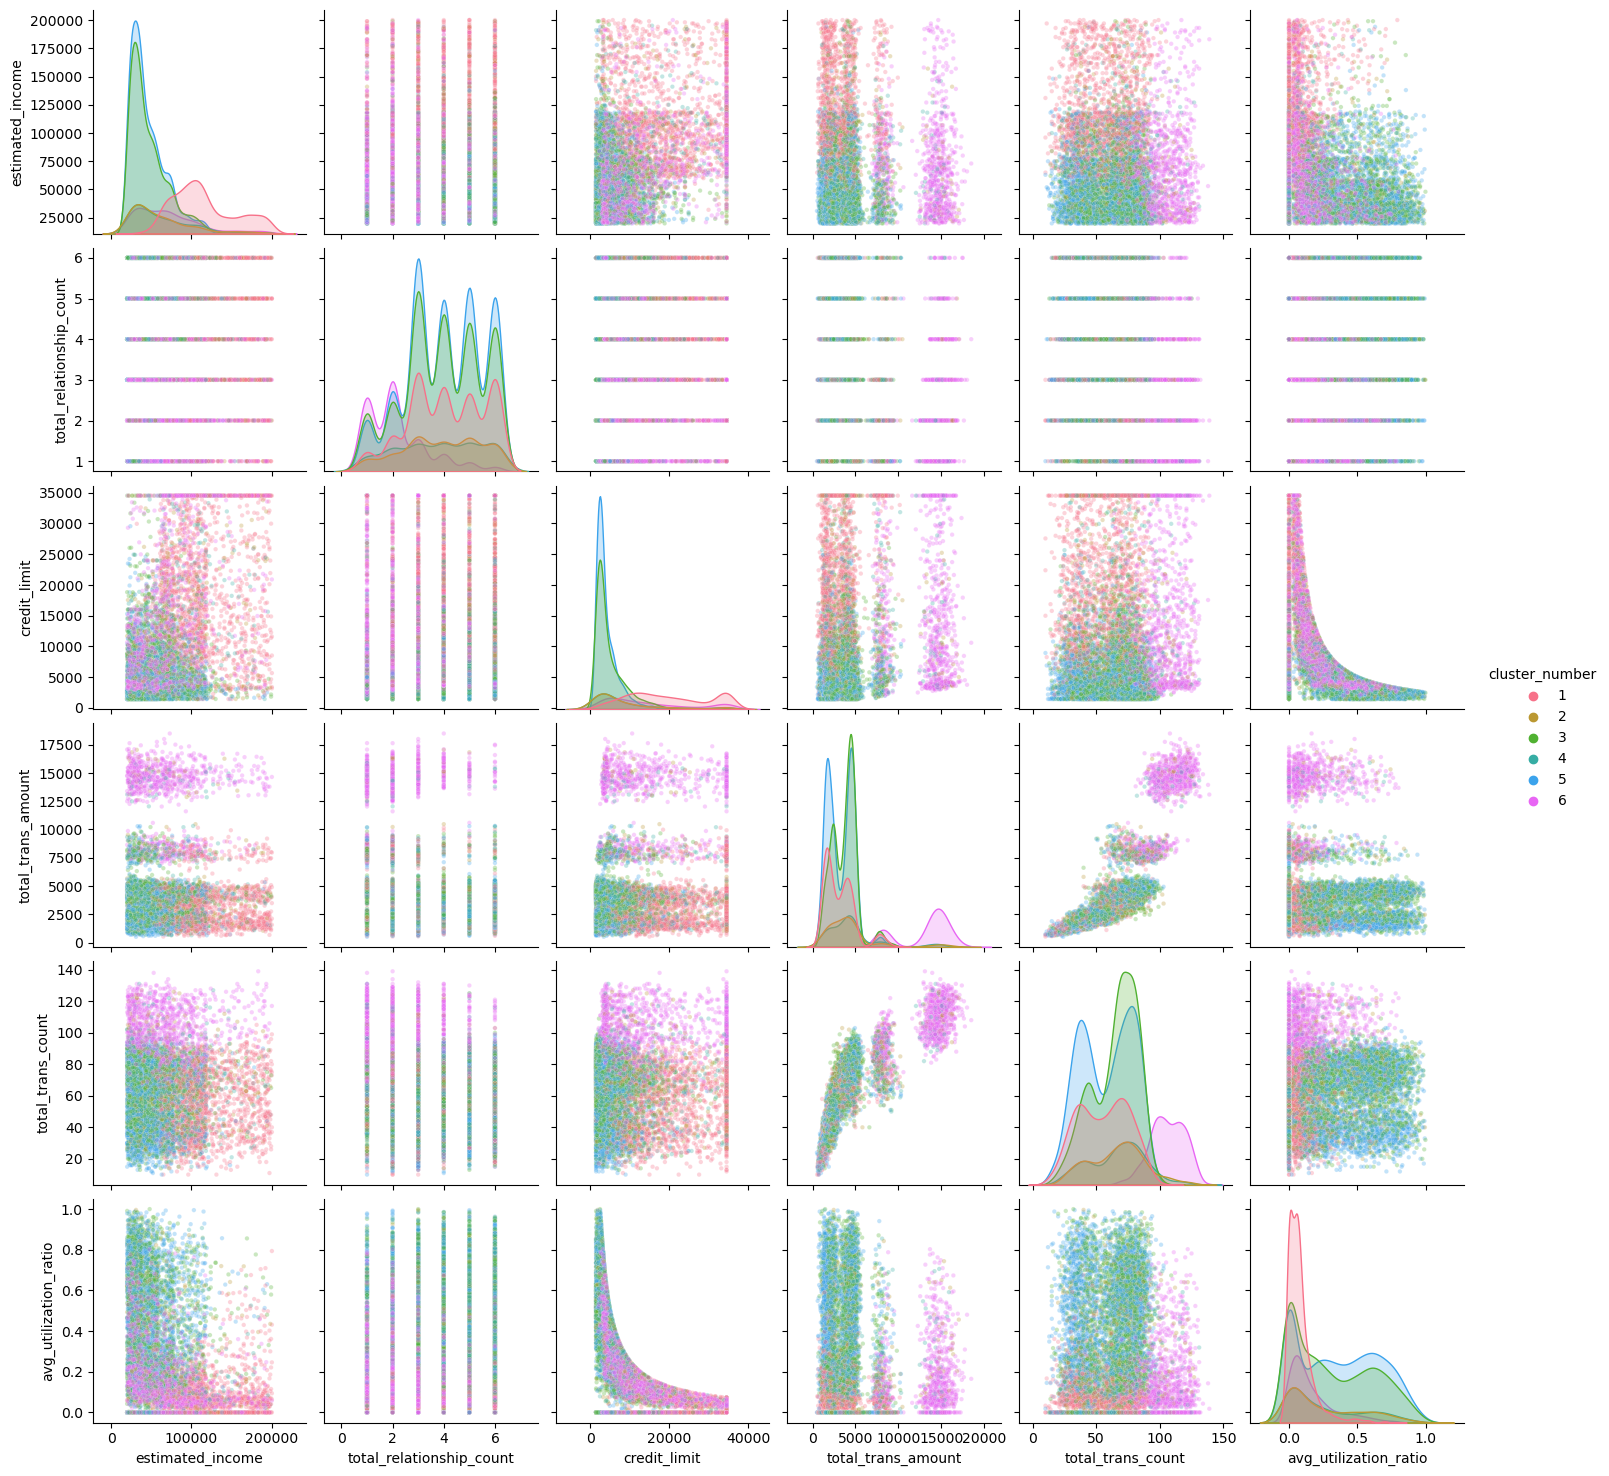

In [89]:
interested_features= ['estimated_income', 'total_relationship_count', 'credit_limit', 'total_trans_amount', 'total_trans_count', 'avg_utilization_ratio']
fig = sns.pairplot(data=ccc_df,
                   vars=interested_features, 
                   hue='cluster_number', 
                   diag_kind='kde',
                   palette=sns.color_palette("husl", len(ccc_df['cluster_number'].unique())),
                   plot_kws={'alpha': 0.3, 's': 10}
                   )

plt.show()

- Cluster 6 has a high total_transaction_amount and total_transaction_count but a really small avg_utilization_ratio and have a big spread on their calculated income. We have big spenders in a big spectrum of income.<br>
- total_trans_amount and total_trans_count really separate the customers into 3 big clusters.


In [95]:
categorical_features = ccc_df.select_dtypes(include=['object'])
categorical_features = pd.concat([categorical_features, ccc_df['cluster_number']], axis=1)
categorical_features.head()

,gender,education_level,marital_status,cluster_number
0,M,High School,Married,1
1,F,Graduate,Single,3
2,M,Graduate,Married,1
3,F,High School,Unknown,4
4,M,Uneducated,Married,5


In [101]:
print(round(pd.crosstab(categorical_features['cluster_number'], categorical_features['gender'], normalize=True) * 100.0, 1))
print(round(pd.crosstab(categorical_features['cluster_number'], categorical_features['education_level'], normalize=True) * 100.0, 1))
print(round(pd.crosstab(categorical_features['cluster_number'], categorical_features['marital_status'], normalize=True) * 100.0, 1))

gender             F     M
cluster_number            
1                0.6  15.9
2                3.9   3.3
3               19.4   9.2
4                3.8   3.6
5               22.3   9.4
6                2.9   5.7
education_level  College  Doctorate  Graduate  High School  Post-Graduate  \
cluster_number                                                              
1                    2.0        0.8       5.9          4.1            1.0   
2                    0.9        0.4       2.5          1.4            0.4   
3                    3.3        1.6      10.4          6.5            1.6   
4                    0.8        0.3       2.6          1.7            0.6   
5                    3.7        1.6      11.8          7.3            2.0   
6                    1.0        0.4       3.1          2.1            0.5   

education_level  Uneducated  
cluster_number               
1                       2.7  
2                       1.5  
3                       5.0  
4                

- Cluster 5 has 25% of the total population as females, also Cluster 3 has a big representation of women
- Cluster 1 his highly represented by Males almost 16% of the customers
- 11% of the customers are in Cluster 5 and have a education level of Graduate, also Cluster 3
- Almost 30 percent of the customers are in Cluster 5 as Married and also 30% but in Cluster 3 as Single

## Final thoughts

The previous observations can be really useful to structure the way to approach each cluster.